In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import math
import xgboost as xgb


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

import pickle

In [81]:
print(pd.__version__)
stores = pd.read_csv(r'C:\Users\guada\OneDrive\Documents\Ironhack\week18\day03\sales.csv')


2.2.2


# 1. Load and Explore the Dataset


In [82]:
stores.head()

,Unnamed: 0,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,425390,366,4,2013-04-18,517,1,0,0,0,4422
1,291687,394,6,2015-04-11,694,1,0,0,0,8297
2,411278,807,4,2013-08-29,970,1,1,0,0,9729
3,664714,802,2,2013-05-28,473,1,1,0,0,6513
4,540835,726,4,2013-10-10,1068,1,1,0,0,10882


In [83]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640840 entries, 0 to 640839
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Unnamed: 0           640840 non-null  int64 
 1   store_ID             640840 non-null  int64 
 2   day_of_week          640840 non-null  int64 
 3   date                 640840 non-null  object
 4   nb_customers_on_day  640840 non-null  int64 
 5   open                 640840 non-null  int64 
 6   promotion            640840 non-null  int64 
 7   state_holiday        640840 non-null  object
 8   school_holiday       640840 non-null  int64 
 9   sales                640840 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 48.9+ MB


# 2. Data cleaning & Feature engineering

In [84]:
stores.dtypes


Unnamed: 0              int64
store_ID                int64
day_of_week             int64
date                   object
nb_customers_on_day     int64
open                    int64
promotion               int64
state_holiday          object
school_holiday          int64
sales                   int64
dtype: object

In [85]:
#Change dtype of 'date' column from object to integer

stores['date'] = pd.to_datetime(stores['date'],format='%Y-%m-%d') # Convert the 'Date' column values from string to datetime
stores['date'] = stores['date'].apply(lambda x: x.toordinal()) # Convert the datetime values to numeric using toordinal()

In [86]:
# Check the unique values in the 'state_holiday' column
print("Unique values in 'state_holiday':")
stores['state_holiday'].unique()

Unique values in 'state_holiday':


array(['0', 'a', 'c', 'b'], dtype=object)

In [87]:
#Change dtype of 'state_holiday' column from object to integer
mapping = {'0': 0, 'a': 1, 'b': 1, 'c': 1}

# Apply the mapping to the 'state_holiday' column
stores['state_holiday'] = stores['state_holiday'].map(mapping)

In [88]:
#Check if there is any missing value
stores.isna().sum()

Unnamed: 0             0
store_ID               0
day_of_week            0
date                   0
nb_customers_on_day    0
open                   0
promotion              0
state_holiday          0
school_holiday         0
sales                  0
dtype: int64

In [89]:
#check if there is a case where the store is closed but sales are not 0
stores[stores["open"]==0]["sales"].unique()

array([0])

In [79]:
# above code shows that when the store is closed the sales are always 0

In [90]:
#check if there is a case where the store is open but there is state holiday.
stores[(stores['state_holiday']==1) & (stores['open']==1)]

,Unnamed: 0,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
216,11690,676,3,735234,946,1,0,1,1,5755
1529,105962,582,1,735393,493,1,0,1,0,2146
1984,582565,178,4,735018,962,1,1,1,0,10796
6382,567148,780,4,735753,1060,1,1,1,0,8646
6465,472005,178,4,735753,964,1,1,1,0,12155
...,...,...,...,...,...,...,...,...,...,...
637520,662068,318,4,735403,755,1,1,1,0,8610
637629,267455,95,4,735753,884,1,1,1,0,8317
638583,424509,777,5,735509,190,1,1,1,0,1880
639009,11063,1074,4,735018,679,1,1,1,0,6758


In [91]:
# re-assessing dtypes
stores.dtypes

Unnamed: 0             int64
store_ID               int64
day_of_week            int64
date                   int64
nb_customers_on_day    int64
open                   int64
promotion              int64
state_holiday          int64
school_holiday         int64
sales                  int64
dtype: object

# 3. Splitting the data


#### Notes: 

We tested other ways of manipulating the data, and other models like linnear regression and KNN with optimized parameters but were getting very low scores
Therefore, we decided to start over on a different approach of manipulating the data (ABOVE)
And we didn't really have time to do all the models again, so we stuck with Decision tree an on.


In [92]:
# since we have established that for store closed, sales are always 0, we will skip predicting those

stores_open = stores[stores['open']==1]
stores_open = stores_open.drop(columns='Unnamed: 0')
stores_open.head()

,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,366,4,734976,517,1,0,0,0,4422
1,394,6,735699,694,1,0,0,0,8297
2,807,4,735109,970,1,1,0,0,9729
3,802,2,735016,473,1,1,0,0,6513
4,726,4,735151,1068,1,1,0,0,10882


In [93]:
X_open = stores_open.drop(columns=['sales'])
y_open= stores_open['sales']

In [94]:
# Split the baseline dataset
X_train_open, X_test_open, y_train_open, y_test_open = train_test_split(X_open, y_open, test_size=0.2, random_state=42)


## * Decision Tree 

In [95]:
# Initialize the Decision Tree Regressor
dt_regressor_open = DecisionTreeRegressor(random_state=42)

# Train on baseline dataset
dt_regressor_open.fit(X_train_open, y_train_open)
y_pred_open = dt_regressor_open.predict(X_test_open)

# Evaluate the baseline model
mse_open = mean_squared_error(y_test_open, y_pred_open)
r2_open = r2_score(y_test_open, y_pred_open)

print(f"Baseline Model - MSE: {mse_open}, R^2: {r2_open}")


Baseline Model - MSE: 1768388.5587008006, R^2: 0.8160326897674801


In [ ]:
# the metrics are good but we are greedy and want to get better

#### - Finding the Optimal Tree Depth

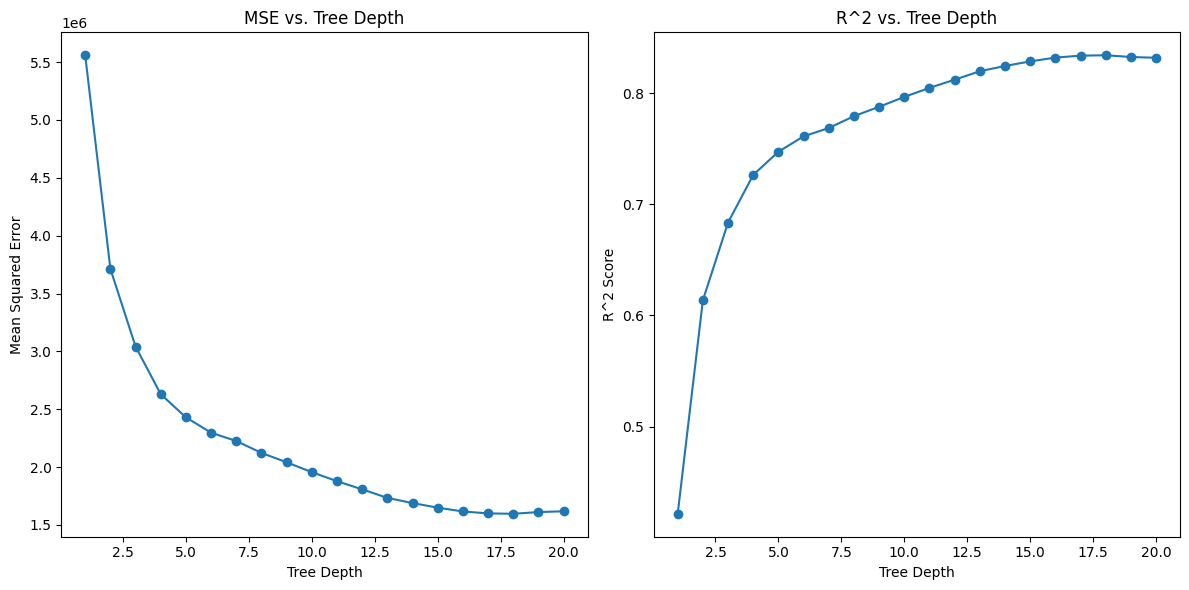

Optimal tree depth: 18


In [96]:
# Lists to store performance metrics
depths = range(1, 21)  # Testing tree depths from 1 to 20
mse_values = []
r2_values = []

for depth in depths:
    # Initialize the Decision Tree Regressor with the current depth
    dt_regressor = DecisionTreeRegressor(max_depth=depth, random_state=42)
    
    # Train the model
    dt_regressor.fit(X_train_open, y_train_open)
    
    # Predict on the test set
    y_pred = dt_regressor.predict(X_test_open)
    
    # Calculate MSE and R^2
    mse = mean_squared_error(y_test_open, y_pred)
    r2 = r2_score(y_test_open, y_pred)
    
    # Store the results
    mse_values.append(mse)
    r2_values.append(r2)

# Plotting the results to find the optimal depth visually
plt.figure(figsize=(12, 6))

# Plot MSE values
plt.subplot(1, 2, 1)
plt.plot(depths, mse_values, marker='o')
plt.title('MSE vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Mean Squared Error')

# Plot R^2 values
plt.subplot(1, 2, 2)
plt.plot(depths, r2_values, marker='o')
plt.title('R^2 vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('R^2 Score')

plt.tight_layout()
plt.show()

# Find the depth with the minimum MSE
optimal_depth = depths[mse_values.index(min(mse_values))]
print(f"Optimal tree depth: {optimal_depth}")

In [99]:
# optimal estimators

# Define a range of n_estimators to test
n_estimators_range = range(10, 201, 10)  # From 10 to 200, in steps of 10


# Lists to store performance metrics
mse_values = []
r2_values = []

for n in n_estimators_values:
    # Initialize the Random Forest Regressor with the current n_estimators and optimal depth
    rf_model = RandomForestRegressor(n_estimators=n, max_depth=optimal_depth, random_state=42)
    
    # Train the model
    rf_model.fit(X_train_open, y_train_open)
    
    # Predict on the test set
    y_pred_rf = rf_model.predict(X_test_open)
    
    # Calculate MSE and R^2
    mse = mean_squared_error(y_test_open, y_pred_rf)
    r2 = r2_score(y_test_open, y_pred_rf)
    
    # Store the results
    mse_values.append(mse)
    r2_values.append(r2)

# Plotting the results to find the optimal n_estimators visually
plt.figure(figsize=(10, 5))
plt.plot(n_estimators_values, mse_values, marker='o')
plt.title('MSE vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error')
plt.show()

# Find the optimal number of estimators based on the lowest MSE
optimal_n_estimators = n_estimators_values[mse_values.index(min(mse_values))]
print(f"Optimal number of estimators: {optimal_n_estimators}")

KeyboardInterrupt: 

In [109]:
# Above we tried to calculate the optimal n_estimators value but the code takes very long to run so, after a few tests, we set it at 200

## Random Forest

In [110]:
# Train the final Random Forest model with the optimal depth and number of estimators
rf_model_optimal = RandomForestRegressor(n_estimators=200, max_depth=optimal_depth, random_state=42)
rf_model_optimal.fit(X_train_open, y_train_open)
y_pred_rf_optimal = rf_model_optimal.predict(X_test_open)

# Evaluate the optimized Random Forest model
rf_optimal_mse = mean_squared_error(y_test_open, y_pred_rf_optimal)
rf_optimal_r2 = r2_score(y_test_open, y_pred_rf_optimal)

print(f"Optimized Random Forest Model - MSE: {rf_optimal_mse}, R^2: {rf_optimal_r2}")

Optimized Random Forest Model - MSE: 1143425.4131805939, R^2: 0.881048259060846


In [ ]:
# we are confident we can go even better than this

## Gradient Boost

In [111]:
# Initialize the Gradient Boosting Regressor with the optimal parameters
gboost_model = GradientBoostingRegressor(n_estimators=200, max_depth=18, random_state=42)
gboost_model.fit(X_train_open, y_train_open)

# Predict on the test set
y_pred_gboost = gboost_model.predict(X_test_open)

# Evaluate the Gradient Boosting model
gboost_mse = mean_squared_error(y_test_open, y_pred_gboost)
gboost_r2 = r2_score(y_test_open, y_pred_gboost)

print(f"Gradient Boosting Model - MSE: {gboost_mse}, R^2: {gboost_r2}")

Gradient Boosting Model - MSE: 539338.0137793832, R^2: 0.9438921026643385


In [112]:
# These metrics are really awesome, we will just see if they can or not be improved

## XGBoost

In [113]:
# Initialize the XGBoost Regressor with the optimal parameters
xgboost_model = xgb.XGBRegressor(n_estimators=200, max_depth=optimal_depth, random_state=42)
xgboost_model.fit(X_train_open, y_train_open)

# Predict on the test set
y_pred_xgboost = xgboost_model.predict(X_test_open)

# Evaluate the XGBoost model
xgboost_mse = mean_squared_error(y_test_open, y_pred_xgboost)
xgboost_r2 = r2_score(y_test_open, y_pred_xgboost)

print(f"XGBoost Model - MSE: {xgboost_mse}, R^2: {xgboost_r2}")

XGBoost Model - MSE: 1235073.5561927594, R^2: 0.8715140223503113


In [ ]:
# no real improvments so we will use our gboost_model

# VALIDATIONS

### Load and explore the validations data

In [114]:
validations = pd.read_csv(r'C:\Users\guada\OneDrive\Documents\Ironhack\week18\day03\validation_for students.csv')

In [115]:
validations.head()

,index,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday
0,272371,415,7,01/03/2015,0,0,0,0,0
1,558468,27,7,29/12/2013,0,0,0,0,0
2,76950,404,3,19/03/2014,657,1,1,0,0
3,77556,683,2,29/01/2013,862,1,0,0,0
4,456344,920,3,19/03/2014,591,1,1,0,0


In [116]:
validations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71205 entries, 0 to 71204
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   index                71205 non-null  int64 
 1   store_ID             71205 non-null  int64 
 2   day_of_week          71205 non-null  int64 
 3   date                 71205 non-null  object
 4   nb_customers_on_day  71205 non-null  int64 
 5   open                 71205 non-null  int64 
 6   promotion            71205 non-null  int64 
 7   state_holiday        71205 non-null  object
 8   school_holiday       71205 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 4.9+ MB


In [117]:
validations.dtypes

index                   int64
store_ID                int64
day_of_week             int64
date                   object
nb_customers_on_day     int64
open                    int64
promotion               int64
state_holiday          object
school_holiday          int64
dtype: object

In [118]:
#Check if there is any missing value
validations.isna().sum()

index                  0
store_ID               0
day_of_week            0
date                   0
nb_customers_on_day    0
open                   0
promotion              0
state_holiday          0
school_holiday         0
dtype: int64

### Validations cleaning & Feature Engineering

In [119]:
validations['date'] = pd.to_datetime(validations['date'], format='%d/%m/%Y') # Convert the 'Date' column values from string to datetime
validations['date'] = validations['date'].apply(lambda x: x.toordinal()) # Convert the datetime values to numeric using toordinal()

In [120]:
print("Unique values in 'state_holiday':")
validations['state_holiday'].unique()


Unique values in 'state_holiday':


array(['0', 'a', 'b', 'c'], dtype=object)

In [121]:
#Change dtype of 'state_holiday' column from object to integer
mapping = {'0': 0, 'a': 1, 'b': 1, 'c': 1}

# Apply the mapping to the 'state_holiday' column
validations['state_holiday'] = validations['state_holiday'].map(mapping)

## Predicting Validations Sales

In [122]:
features_columns = ['store_ID', 'day_of_week', 'date', 'nb_customers_on_day', 'open', 'promotion', 'state_holiday', 'school_holiday']

In [123]:
def custom_predict(data, model, features_columns):
    # If the store is closed, predict 0 sales
    if data['open'] == 0:
        return 0
    # Otherwise, use the model to predict the sales
    else:
        # Convert the input data (a Series) to a DataFrame with correct feature names
        features_df = pd.DataFrame([data[features_columns].values], columns=features_columns)
        return model.predict(features_df)[0]

In [73]:
# Apply the custom prediction function to each row of the new dataset
validations['predicted_sales'] = validations.apply(lambda x: custom_predict(x, gboost_model, features_columns), axis=1)


In [76]:
validations.head()

,index,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,predicted_sales
0,272371,415,7,735658,0,0,0,0,0,0.000000
1,558468,27,7,735231,0,0,0,0,0,0.000000
2,76950,404,3,735311,657,1,1,0,0,5948.456396
3,77556,683,2,734897,862,1,0,0,0,7897.618575
4,456344,920,3,735311,591,1,1,0,0,6041.462528


In [78]:
# Save predicted sales to csv
validations[['index', 'predicted_sales']].to_csv('sales_predicted.csv', index=False)

## SAVE THE MODEL TO A PICKLE FILE

In [124]:
# Save the model to a pickle file
with open('gboost_model.pkl', 'wb') as file:
    pickle.dump(gboost_model, file)